In [1]:
# from pyarrow import csv
import pandas as pd
from collections import Counter
from IPython.display import display, clear_output
import numpy as np

In [2]:
import matplotlib.pyplot as plt
import gzip
import pickle

In [3]:
HOST_LOGS = pd.read_csv("./NGIDS_host_log.csv")

In [4]:
HOST_LOGS

,Unnamed: 0,date_time,pro_id,path,sys_call,event_id,attack_cat,attack_subcat,label
0,0,2016-03-11 02:45:01,1951,14,168,45350,0,0,0
1,1,2016-03-11 02:45:01,1966,14,168,45351,0,0,0
2,2,2016-03-11 02:45:01,1885,5,168,45353,0,0,0
3,3,2016-03-11 02:45:01,1830,15,142,45354,0,0,0
4,4,2016-03-11 02:45:01,1872,5,168,45355,0,0,0
...,...,...,...,...,...,...,...,...,...
90054234,90054234,2016-03-16 19:45:19,22939,22,221,102975641,0,0,0
90054235,90054235,2016-03-16 19:45:19,22939,22,102,102975643,0,0,0
90054236,90054236,2016-03-16 19:45:19,16489,25,7,102975644,0,0,0
90054237,90054237,2016-03-16 19:45:19,11364,1,256,102975646,0,0,0


In [5]:
def vc_mapping(DF, column):
    df_tmp = DF
    tmp = DF[column].value_counts().index
    print(column, len(tmp))
    dict_tmp = dict()
    for i, t in enumerate(tmp):
        dict_tmp[t] = i+1
    DF[column] = DF[column].map(dict_tmp)
    return DF

In [6]:
HOST_LOGS = vc_mapping(HOST_LOGS, "date_time")
HOST_LOGS = vc_mapping(HOST_LOGS, "path")
HOST_LOGS = vc_mapping(HOST_LOGS, "sys_call")
HOST_LOGS = vc_mapping(HOST_LOGS, "attack_cat")

date_time 367290
path 100
sys_call 122
attack_cat 8


In [7]:
DATE_TIME = HOST_LOGS["date_time"].values.astype("int32")

In [8]:
ATTACK_CAT = HOST_LOGS["attack_cat"].values.astype("int16")

In [9]:
PS_V = HOST_LOGS[["path", "sys_call"]].values

In [10]:
PS_DD_V = HOST_LOGS[["path", "sys_call"]].drop_duplicates().values

In [17]:
x = PS_DD_V[:,0]
y = PS_DD_V[:,1]

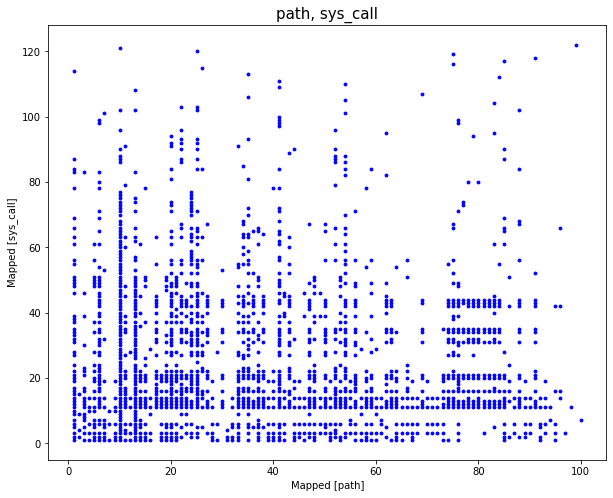

In [30]:
plt.figure(figsize=(10,8))

plt.scatter(x, y, s=8, c='b', alpha=1)

plt.title("path, sys_call", fontsize=15)
plt.xlabel("Mapped [path]")
plt.ylabel("Mapped [sys_call]")

plt.show()

In [12]:
PS_DICT = dict()
for i, V in enumerate(PS_DD_V):
    PS_DICT[tuple(V)] = i+1

In [13]:
PS = np.zeros(len(PS_V))
for i, V in enumerate(PS_V):
    PS[i] = PS_DICT[tuple(V)]

In [14]:
del HOST_LOGS, PS_V, PS_DD_V, PS_DICT

In [15]:
def most_com(list):
    return Counter(list).most_common(n=1)[0][0]

In [16]:
def sliding_window_arr(vecs, Arr, window=5, jump=10):
    Arr_len = len(Arr)
    y_len = int(((Arr_len-window)/jump) + 1)
    res = vecs
    for i in range(y_len):
        res.append(Arr[i*jump:i*jump + window])
    return res, y_len

In [17]:
def padding(re, len_tmp, cut):
    re = np.array(re)
    if len_tmp>=cut:
        re = re[:cut]
    else:
        tmp = np.zeros(cut)
        tmp[:len(re)] = re
        re = tmp
    return re

In [18]:
def make_SW_vector(WINDOW):
    vecs = []
    atcas = []
    start = 0
    end = 0
    check = DATE_TIME[0]
    for i, DT in enumerate(DATE_TIME):
        if (check != DT) | (i == (len(DATE_TIME) - 1)):
            check = DT
            end = i
            len_tmp = end-start

            l_val = most_com(ATTACK_CAT[start:end])
            if l_val!=(np.mean(ATTACK_CAT[start:end])):
                print("ATTACK_CAT_ERR!!", DT)
                break

            
            vecs.append(padding(PS[start:end], len_tmp, WINDOW))
            atcas.append(l_val)
            start = i
            
        if i%1000000 == 0:
            print("processing...",i)
            clear_output(wait=True)
    col = []
    for i in range(WINDOW):
        col.append("sys"+str(i+1))
    vecs = pd.DataFrame(vecs, columns=col)
    vecs["attack_cat"] = atcas
    return vecs

In [46]:
START = 64
LAST = 600

In [20]:
NGIDS_MAP = make_SW_vector(LAST)

processing... 90000000


In [21]:
NGIDS_MAP.shape

(367290, 601)

In [22]:
col = []
for i in range(LAST):
    col.append("sys"+str(i+1))

In [23]:
NGIDS_MAP = NGIDS_MAP.drop_duplicates()

In [24]:
NGIDS_MAP.shape

(306634, 601)

In [25]:
ng_len = NGIDS_MAP.shape[0]

In [26]:
# y = NGIDS_MAP["attack_cat"]
# NGIDS_MAP = NGIDS_MAP.drop(NGIDS_MAP.columns[0], axis=1)
# NGIDS_MAP = NGIDS_MAP.drop(NGIDS_MAP.columns[-1], axis=1)

In [27]:
def cut_drop_duplicate_len(DF, col, cut):
    col_tmp = col[:cut]
    DF_tmp = DF[col_tmp]
    DF_tmp["attack_cat"] = DF["attack_cat"]
    DF_tmp = DF_tmp.drop_duplicates()
    DF_tmp_2 = DF_tmp.drop_duplicates(col_tmp)
    
    rate = (DF_tmp_2.shape[0]/DF_tmp.shape[0])*100
    
    return rate

In [28]:
rate_arr = []
flag=0
first_index=0
last_index=0
for i in range(START, LAST+1):
    rate = cut_drop_duplicate_len(NGIDS_MAP, col, i)
    print(i, ":", "rate : ", rate)
    if rate>=100:
        flag+=1
        if flag==1:
            first_index=i
    if flag>=5:
        last_index=i
        break
    rate_arr.append(rate)
if first_index==0:
    first_index = LAST
if last_index==0:
    last_index = LAST

<ipython-input-27-c4091de543fe>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DF_tmp["attack_cat"] = DF["attack_cat"]


64 : rate :  98.86770115428523
65 : rate :  98.88650110769078
66 : rate :  98.91420681541516
67 : rate :  98.93232403118292
68 : rate :  98.94553807867786
69 : rate :  98.9700926209611
70 : rate :  98.98345098587393
71 : rate :  98.99375699845075
72 : rate :  99.00891746792442
73 : rate :  99.01398847655226
74 : rate :  99.0244913366245
75 : rate :  99.03771512266569
76 : rate :  99.05292882484976
77 : rate :  99.07503155732736
78 : rate :  99.08576741303169
79 : rate :  99.09576911832268
80 : rate :  99.10999229668758
81 : rate :  99.1246505743843
82 : rate :  99.138336943215
83 : rate :  99.14850522023599
84 : rate :  99.15637140765267
85 : rate :  99.175078905496
86 : rate :  99.18509143506562
87 : rate :  99.18882783062622
88 : rate :  99.19647715337796
89 : rate :  99.21743046954172
90 : rate :  99.23141661922324
91 : rate :  99.24248000392562
92 : rate :  99.25395259906456
93 : rate :  99.27024230096706
94 : rate :  99.28441757583235
95 : rate :  99.29474283986652
96 : rate :  99

323 : rate :  99.85272796892232
324 : rate :  99.85310475691945
325 : rate :  99.85312109495116
326 : rate :  99.85313262549147
327 : rate :  99.85316240434298
328 : rate :  99.85351386877066
329 : rate :  99.85352680001832
330 : rate :  99.85353781372494
331 : rate :  99.85456850967037
332 : rate :  99.85494794133885
333 : rate :  99.85495836586425
334 : rate :  99.85496926262975
335 : rate :  99.85497684202275
336 : rate :  99.85498584152303
337 : rate :  99.85498963045217
338 : rate :  99.85499341918333
339 : rate :  99.85500951908224
340 : rate :  99.85502845556329
341 : rate :  99.85504076162367
342 : rate :  99.85505495832831
343 : rate :  99.85538660416408
344 : rate :  99.85539038068563
345 : rate :  99.85572340675553
346 : rate :  99.85574742091401
347 : rate :  99.85575212863516
348 : rate :  99.85575636532148
349 : rate :  99.85577189770899
350 : rate :  99.85578460353817
351 : rate :  99.85578883831711
352 : rate :  99.85578930883274
353 : rate :  99.85579166136489
354 : ra

580 : rate :  99.85585421055721
581 : rate :  99.85585421055721
582 : rate :  99.85585421055721
583 : rate :  99.85585421055721
584 : rate :  99.85585421055721
585 : rate :  99.85585421055721
586 : rate :  99.85585421055721
587 : rate :  99.85585421055721
588 : rate :  99.85585421055721
589 : rate :  99.85585421055721
590 : rate :  99.85585421055721
591 : rate :  99.85585421055721
592 : rate :  99.85585421055721
593 : rate :  99.85585421055721
594 : rate :  99.85585421055721
595 : rate :  99.85585421055721
596 : rate :  99.85585421055721
597 : rate :  99.85585421055721
598 : rate :  99.85585421055721
599 : rate :  99.85585421055721
600 : rate :  99.85585421055721


In [82]:
with gzip.open("./cutting_test_rate_arr.pkl", "wb") as f:
    pickle.dump(rate_arr, f)

In [83]:
with gzip.open("./cutting_test_rate_arr.pkl", "rb") as f:
    tmp = pickle.load(f)

In [84]:
tmp

[98.86770115428523,
 98.88650110769078,
 98.91420681541516,
 98.93232403118292,
 98.94553807867786,
 98.9700926209611,
 98.98345098587393,
 98.99375699845075,
 99.00891746792442,
 99.01398847655226,
 99.0244913366245,
 99.03771512266569,
 99.05292882484976,
 99.07503155732736,
 99.08576741303169,
 99.09576911832268,
 99.10999229668758,
 99.1246505743843,
 99.138336943215,
 99.14850522023599,
 99.15637140765267,
 99.175078905496,
 99.18509143506562,
 99.18882783062622,
 99.19647715337796,
 99.21743046954172,
 99.23141661922324,
 99.24248000392562,
 99.25395259906456,
 99.27024230096706,
 99.28441757583235,
 99.29474283986652,
 99.30468848440417,
 99.3338130628858,
 99.35331081568249,
 99.3667134954781,
 99.37645003758605,
 99.39991609446277,
 99.41060903732809,
 99.41911350990893,
 99.42992041565296,
 99.44043827239139,
 99.44715644360895,
 99.45365883025798,
 99.45978480930802,
 99.46949733021448,
 99.47743654411367,
 99.48469957887855,
 99.49085523736697,
 99.49892489632929,
 99.50534

In [47]:
x = [72, 113, 198, 371, 387]
y = np.zeros(len(x))
for i,v in enumerate(y):
    y[i] = rate_arr[x[i]-START]

<function matplotlib.pyplot.show(close=None, block=None)>

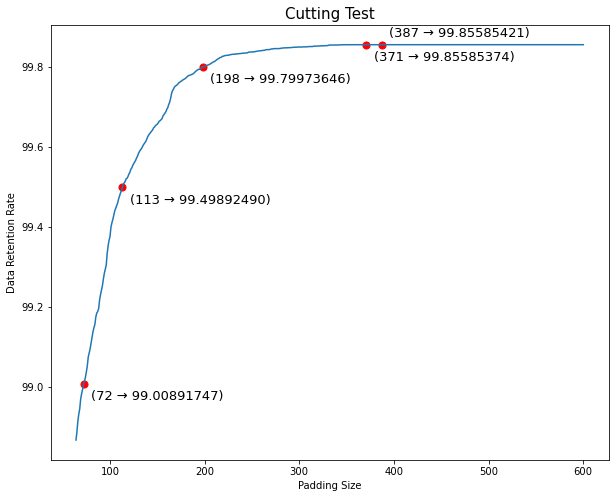

In [80]:
plt.figure(figsize=(10,8))
plt.plot(np.arange(START,last_index+1,1), rate_arr)
plt.scatter(x, y, s=50, c='r', alpha=1)

for i in range(len(x)-1):
    tmp = "({0} → {1:.8f})".format(x[i], y[i])
    plt.text(x[i]+8, y[i]-0.04, s=tmp, fontsize=13)
    
tmp = "({0} → {1:.8f})".format(x[-1], y[-1])
plt.text(x[-1]+8, y[-1]+0.02, s=tmp, fontsize=13)
    
plt.title("Cutting Test", fontsize=15)
plt.xlabel("Padding Size")
plt.ylabel("Data Retention Rate")
# plt.axvline(x=first_index-1, color='r', lw=1, label=str(first_index-1))
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

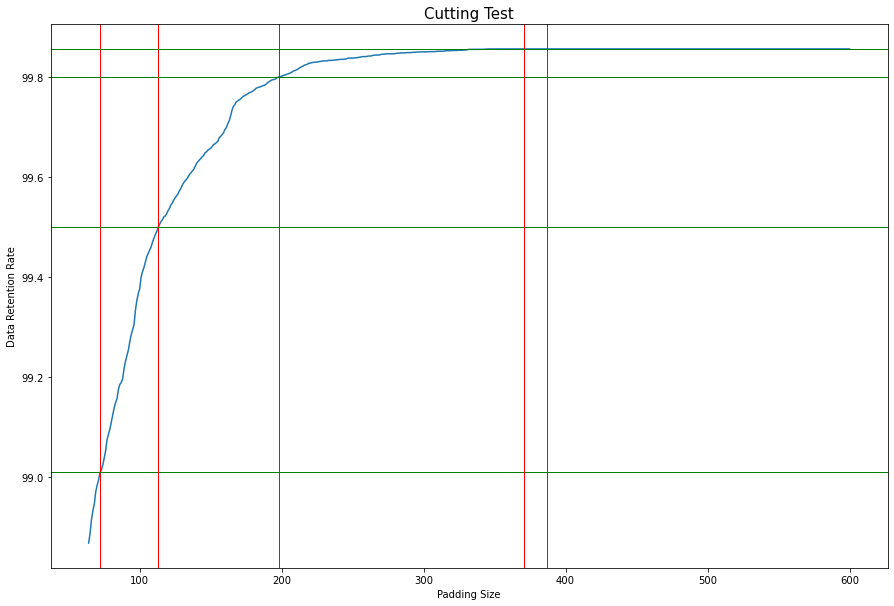

In [44]:
plt.figure(figsize=(15,10))
plt.plot(np.arange(64,last_index+1,1), rate_arr)
plt.axvline(x=72, color='r', lw=1, label=str(72))
plt.axhline(y=rate_arr[72-64], color='g', lw=1, label=str(rate_arr[72-64]))

plt.axvline(x=113, color='r', lw=1, label=str(113))
plt.axhline(y=rate_arr[113-64], color='g', lw=1, label=str(rate_arr[113-64]))

plt.axvline(x=198, color='r', lw=1, label=str(198))
plt.axhline(y=rate_arr[198-64], color='g', lw=1, label=str(rate_arr[198-64]))

plt.axvline(x=371, color='r', lw=1, label=str(371))
plt.axhline(y=rate_arr[371-64], color='g', lw=1, label=str(rate_arr[371-64]))

plt.axvline(x=387, color='r', lw=1, label=str(387))
plt.axhline(y=rate_arr[387-64], color='g', lw=1, label=str(rate_arr[387-64]))

plt.label()

plt.title("Cutting Test", fontsize=15)
plt.xlabel("Padding Size")
plt.ylabel("Data Retention Rate")
# plt.axvline(x=first_index-1, color='r', lw=1, label=str(first_index-1))
plt.show

In [ ]:
def cut_drop_duplicate_df(DF, col, cut):
    col_tmp = col[:cut]
    DF_tmp = DF[col_tmp]
    DF_tmp = DF_tmp.drop_duplicates(col_tmp)
    return DF_tmp

In [ ]:
cut_df = cut_drop_duplicate_df(NGIDS_MAP, col, 371)

In [ ]:
cut_df["attack_cat"] = y

In [ ]:
cut_df.to_csv("./NGIDS_DATA_371.csv")